In [15]:
# import pre-processed data
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras import applications, layers, losses, optimizers, Model
from tensorflow.keras.models import Sequential
import keras_toolkit as kt
import keras.backend as K
from sklearn.model_selection import train_test_split
from textwrap import wrap
from sklearn.neighbors import KNeighborsClassifier


In [16]:
# # change tensorflow device to GPU
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Pre-process image data so that it can be used in the model

In [2]:
PATH = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/'
PATH_TO_IMG = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/train_images/'
PATH_TO_TEST = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/test_images/'
os.listdir(PATH)

['test.csv',
 'train_images',
 'train.csv',
 'sample_submission.csv',
 'test_images']

In [27]:
# how many images are there in trainig set
len(os.listdir(PATH_TO_IMG))

32411

## Show some images

In [28]:
COMPUTE_CV = True
if len(pd.read_csv(PATH + 'test.csv')) > 3: COMPUTE_CV = False

In [29]:
if COMPUTE_CV:
    dataset = pd.read_csv(PATH + 'train.csv')
    tmp = dataset.groupby('label_group').posting_id.agg('unique').to_dict() 
    dataset['target'] = dataset.label_group.map(tmp) # map the posting_ids that have same image
else:    
    dataset = pd.read_csv(PATH + 'test.csv')

In [30]:
dataset.head()

,posting_id,image,image_phash,title,label_group,target
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]"
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]"
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]"


In [31]:
def show_random_img():
    # choose randomly two instances per each class
    labels_to_show = np.random.choice(dataset.label_group.unique(), 
                                      replace=False, size=27)
    img_to_show = []
    for label in labels_to_show:
        rows = dataset[dataset.label_group==label].copy()
        pair = np.random.choice([i for i in range(len(rows))], 
                                    replace=False, size=2)
        img_pair = rows.iloc[pair][['image', 'title']].values
        
        img_to_show += list(img_pair)
    
    fig, axes = plt.subplots(figsize = (18, 12), nrows=4,ncols=6)
    for imp, ax in zip(img_to_show, axes.ravel()):
        img = cv2.imread(PATH_TO_IMG + imp[0])
        title = '\n'.join(wrap(imp[1], 20))
        ax.set_title(title)
        ax.imshow(img)
        ax.axis('off')

    fig.tight_layout()

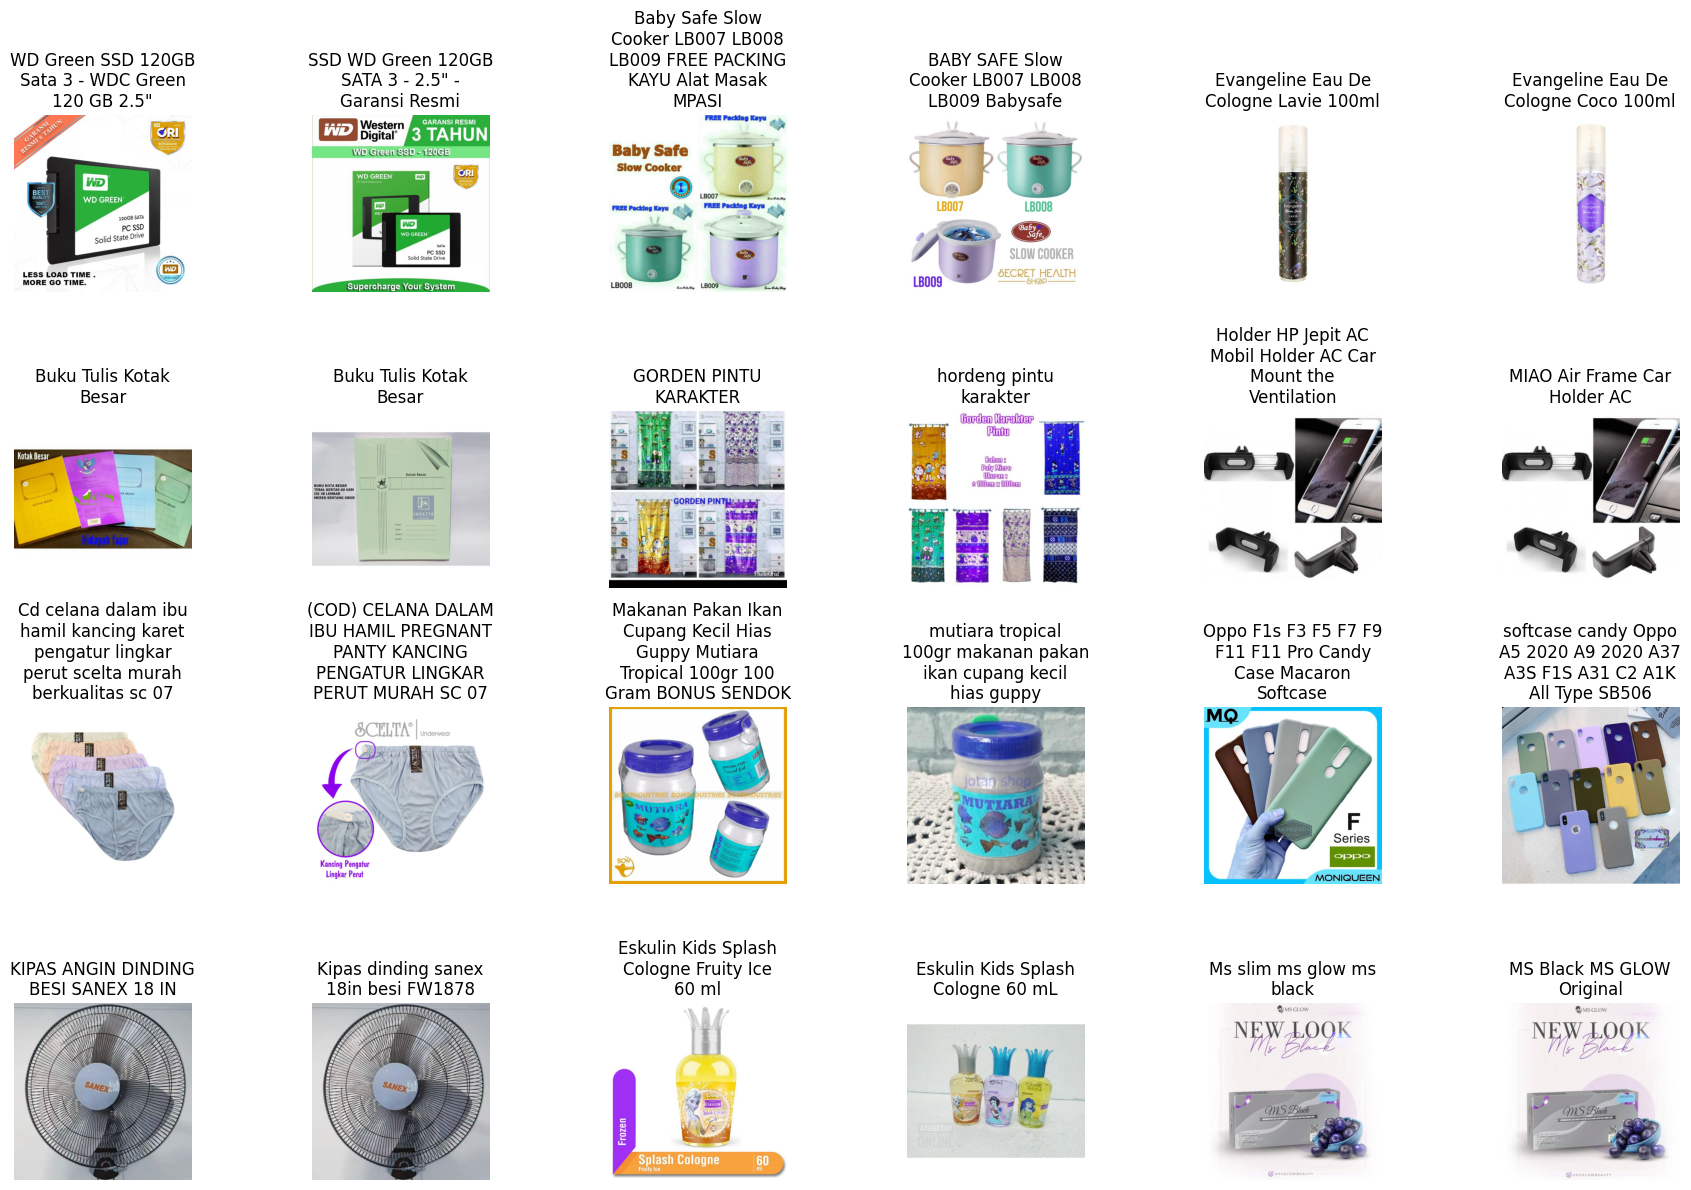

In [32]:
if COMPUTE_CV:
    show_random_img()

## [Done] Reorganize the data into a directory structure that can be used by the model

In [33]:
# create 20_intermediate_data folder if not exist
# if not os.path.exists('/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data'):
#     os.mkdir('/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data')
#     print("Folder Created")
# else:
#     print("Folder already exists")

In [34]:
# create folder for each class
# for label in dataset.label_group.unique():
#     if not os.path.exists('/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data/' + str(label)):
#         os.mkdir('/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data/' + str(label))
#         print("Folder Created")
#     else:
#         print("Folder already exists")

In [35]:
# copy images to their respective class folder
# for label in dataset.label_group.unique():
#     for img in dataset[dataset.label_group==label].image.values:
#         os.system('cp ' + PATH_TO_IMG + img + ' /workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data/' + str(label) + '/')
#         print("Image copied")

## Set up and Train the Model

In [4]:
# create train and validation set
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/workspaces/Shopee-Price-Match-Guarantee/15_after_processed/train_images/',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224), # change from 256 to 224
    # validation_split=0.2,
    # subset="training",
    # seed=17,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/workspaces/Shopee-Price-Match-Guarantee/15_after_processed/val_images/',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    # validation_split=0.2,
    # subset="validation",
    # seed=17,
)

Found 21108 files belonging to 10019 classes.
Found 5414 files belonging to 4190 classes.


In [5]:
# check the image size
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

2023-04-16 17:01:52.706581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [21108]
	 [[{{node Placeholder/_4}}]]
2023-04-16 17:01:52.707189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [21108]
	 [[{{node Placeholder/_0}}]]


(32, 224, 224, 3)
(32, 10019)


In [6]:
num_classes = len(train_ds.class_names)
print(f"We have {num_classes} classes.")

We have 10019 classes.


In [7]:
class_names = train_ds.class_names
# print(class_names)

In [33]:
def preprocess_labels(image, label):
    label = tf.argmax(label, axis=-1)
    label = tf.one_hot(label, num_classes)
    return image, label
# Preprocess the labels in the validation set
val_ds = val_ds.map(preprocess_labels)

### Visualize 6 images from the training set

2023-04-11 21:46:08.082692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [25968]
	 [[{{node Placeholder/_0}}]]
2023-04-11 21:46:08.083086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [25968]
	 [[{{node Placeholder/_4}}]]


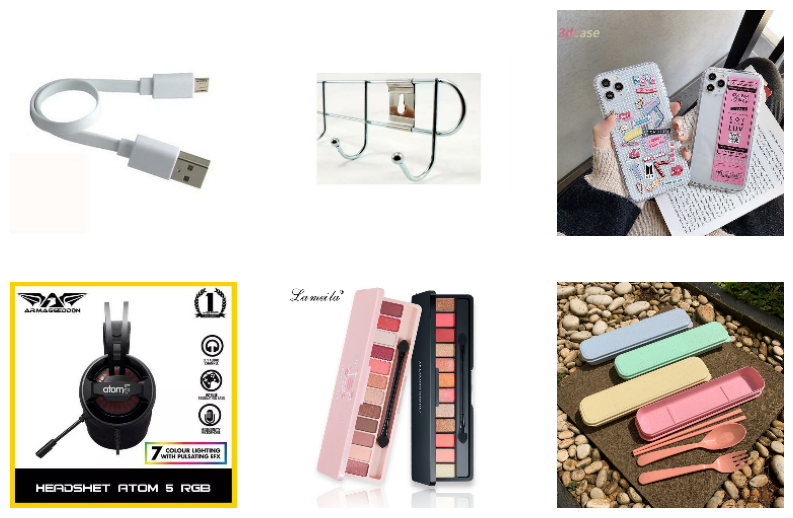

In [40]:
import matplotlib.pyplot as plotter_lib

plotter_lib.figure(figsize=(10, 10))

epochs=10

for images, labels in train_ds.take(1):

  for var in range(6):

    ax = plt.subplot(3, 3, var + 1)

    plotter_lib.imshow(images[var].numpy().astype("uint8"))

    plotter_lib.axis("off")

## Train and Evaluate the Model

### ResNet50

In [17]:
KNN = KNeighborsClassifier(n_neighbors=1, metric='cosine')

In [41]:
# import the ResNet50 model from keras

resnet = Sequential()
pretrained_model = applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3), # change from 256 to 224
    pooling='avg',
    classes=num_classes,
    # classifier_activation='softmax',
)

for layer in pretrained_model.layers:
    layer.trainable = False

resnet.add(pretrained_model)
# add batch normalization layer
resnet.add(BatchNormalization())
# flatten the output
resnet.add(Flatten())
# add dropout layer
resnet.add(Dropout(0.5))
# add linear layer for reduction
resnet.add(Dense(512, activation='linear'))
# add knn classification layer
resnet.add(Dense(num_classes, activation='softmax'))

# add a fully connected layer
# resnet.add(Flatten())
# resnet.add(Dense(512, activation='relu'))
# resnet.add(Dense(num_classes, activation='softmax'))


# save the model
# if not os.path.exists('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50'):
#     os.mkdir('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50')
#     print("Folder Created")
#     model.save('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50/resnet50v2.h5')
#     print("Model Saved")
# else:
#     print("Folder already exists")
#     model.save('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50/resnet50v2.h5')
#     print("Model Saved")

In [42]:
resnet.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_5 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 10019)             5139747   
                                                      

In [43]:
epochs=1
# default was set to 10

In [44]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [45]:
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)
# optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

In [46]:
optimizer = keras.optimizers.Adam(learning_rate=0.0007)

In [47]:
resnet.compile(optimizer=optimizer, 
                loss='categorical_crossentropy',
                metrics=[get_f1])

# setting up checkpoints
# mkdir /workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50/checkpoints if not exist
if not os.path.exists('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50'):
    os.mkdir('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50')
    print("Folder Created")
else:
    print("Folder already exists")
if not os.path.exists('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50/checkpoints'):
    os.mkdir('/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50/checkpoints')
    print("Folder Created")
else:
    print("Folder already exists")
    
checkpoint_filepath = '/workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50/checkpoints/cp-{epoch:04d}.ckpt'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    verbose=1,
    save_freq='epoch')

# load checkpoint if exist
# resnet.load_weights(checkpoint_filepath)

resnet.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[model_checkpoint_callback])
# history = resnet.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[model_checkpoint_callback])


Folder already exists
Folder already exists
660/660 [==============================] - ETA: 0s - loss: 7.6471 - get_f1: 0.0872
Epoch 1: val_loss improved from inf to 11.02430, saving model to /workspaces/Shopee-Price-Match-Guarantee/30_results/ResNet50/checkpoints/cp-0001.ckpt
660/660 [==============================] - 477s 719ms/step - loss: 7.6471 - get_f1: 0.0872 - val_loss: 11.0243 - val_get_f1: 3.0960e-04
